In [1]:
from qiskit import IBMQ

import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister
from qiskit.circuit.library import IntegerComparator
from qiskit_algorithms import IterativeAmplitudeEstimation, EstimationProblem
from qiskit_aer.primitives import Sampler
from qiskit_finance.circuit.library import GaussianConditionalIndependenceModel as GCI
from qiskit.providers.ibmq import least_busy
from qiskit import execute, Aer
from qiskit.qasm import pi

import math

from qiskit.primitives import BackendSampler

In [2]:
num = 5 #株の数（もしくは変動日数）
theta = math.pi/2 #株の上下変動のしやすさ

In [3]:
qc = QuantumCircuit(num)

for i in range(num):
    qc.ry(theta,i)

qc_measure = qc.measure_all(inplace=False)

qc.draw()

┌─────────┐
q_0: ┤ Ry(π/2) ├
     ├─────────┤
q_1: ┤ Ry(π/2) ├
     ├─────────┤
q_2: ┤ Ry(π/2) ├
     ├─────────┤
q_3: ┤ Ry(π/2) ├
     ├─────────┤
q_4: ┤ Ry(π/2) ├
     └─────────┘

In [4]:
from qiskit.circuit.library import WeightedAdder
from qiskit.circuit.library import LinearAmplitudeFunction

agg = WeightedAdder(num, [10,10,10,10,10])

qr_state = QuantumRegister(qc.num_qubits, "state")
qr_sum = QuantumRegister(agg.num_sum_qubits, "sum")
qr_carry = QuantumRegister(agg.num_carry_qubits+1, "carry")
cr = ClassicalRegister(agg.num_sum_qubits, "value")

L_sum_state = QuantumCircuit(qr_state, qr_sum, qr_carry, cr)

# load the variable
L_sum_state.append(qc.to_gate(), qr_state)

# aggregate
L_sum_state.append(agg.to_gate(), qr_state[:] + qr_sum[:] + qr_carry[:])

L_sum_state.measure(qr_sum[:],cr[:])

L_sum_state.draw()

┌──────────────┐┌─────────┐                  
state_0: ┤0             ├┤0        ├──────────────────
         │              ││         │                  
state_1: ┤1             ├┤1        ├──────────────────
         │              ││         │                  
state_2: ┤2 circuit-161 ├┤2        ├──────────────────
         │              ││         │                  
state_3: ┤3             ├┤3        ├──────────────────
         │              ││         │                  
state_4: ┤4             ├┤4        ├──────────────────
         └──────────────┘│         │┌─┐               
  sum_0: ────────────────┤5        ├┤M├───────────────
                         │         │└╥┘┌─┐            
  sum_1: ────────────────┤6        ├─╫─┤M├────────────
                         │         │ ║ └╥┘┌─┐         
  sum_2: ────────────────┤7        ├─╫──╫─┤M├─────────
                         │         │ ║  ║ └╥┘┌─┐      
  sum_3: ────────────────┤8  adder ├─╫──╫──╫─┤M├──────
                         │         │ ║  ║  ║ └╥┘┌─┐   
  sum_4: ────────────────┤9        ├─╫──╫──╫──╫─┤M├───
                         │         │ ║  ║  ║  ║ └╥┘┌─┐
  sum_5: ────────────────┤10       ├─╫──╫──╫──╫──╫─┤M├
                         │         │ ║  ║  ║  ║  ║ └╥┘
carry_0: ────────────────┤11       ├─╫──╫──╫──╫──╫──╫─
                         │         │ ║  ║  ║  ║  ║  ║ 
carry_1: ────────────────┤12       ├─╫──╫──╫──╫──╫──╫─
                         │         │ ║  ║  ║  ║  ║  ║ 
carry_2: ────────────────┤13       ├─╫──╫──╫──╫──╫──╫─
                         │         │ ║  ║  ║  ║  ║  ║ 
carry_3: ────────────────┤14       ├─╫──╫──╫──╫──╫──╫─
                         │         │ ║  ║  ║  ║  ║  ║ 
carry_4: ────────────────┤15       ├─╫──╫──╫──╫──╫──╫─
                         │         │ ║  ║  ║  ║  ║  ║ 
carry_5: ────────────────┤16       ├─╫──╫──╫──╫──╫──╫─
                         └─────────┘ ║  ║  ║  ║  ║  ║ 
value: 6/════════════════════════════╩══╩══╩══╩══╩══╩═
                                     0  1  2  3  4  5

In [8]:
L_sum_state.decompose().draw()

┌─────────┐┌───────────────┐                  
state_0: ┤ Ry(π/2) ├┤0              ├──────────────────
         ├─────────┤│               │                  
state_1: ┤ Ry(π/2) ├┤1              ├──────────────────
         ├─────────┤│               │                  
state_2: ┤ Ry(π/2) ├┤2              ├──────────────────
         ├─────────┤│               │                  
state_3: ┤ Ry(π/2) ├┤3              ├──────────────────
         ├─────────┤│               │                  
state_4: ┤ Ry(π/2) ├┤4              ├──────────────────
         └─────────┘│               │┌─┐               
  sum_0: ───────────┤5              ├┤M├───────────────
                    │               │└╥┘┌─┐            
  sum_1: ───────────┤6              ├─╫─┤M├────────────
                    │               │ ║ └╥┘┌─┐         
  sum_2: ───────────┤7              ├─╫──╫─┤M├─────────
                    │               │ ║  ║ └╥┘┌─┐      
  sum_3: ───────────┤8  circuit-165 ├─╫──╫──╫─┤M├──────
                    │               │ ║  ║  ║ └╥┘┌─┐   
  sum_4: ───────────┤9              ├─╫──╫──╫──╫─┤M├───
                    │               │ ║  ║  ║  ║ └╥┘┌─┐
  sum_5: ───────────┤10             ├─╫──╫──╫──╫──╫─┤M├
                    │               │ ║  ║  ║  ║  ║ └╥┘
carry_0: ───────────┤11             ├─╫──╫──╫──╫──╫──╫─
                    │               │ ║  ║  ║  ║  ║  ║ 
carry_1: ───────────┤12             ├─╫──╫──╫──╫──╫──╫─
                    │               │ ║  ║  ║  ║  ║  ║ 
carry_2: ───────────┤13             ├─╫──╫──╫──╫──╫──╫─
                    │               │ ║  ║  ║  ║  ║  ║ 
carry_3: ───────────┤14             ├─╫──╫──╫──╫──╫──╫─
                    │               │ ║  ║  ║  ║  ║  ║ 
carry_4: ───────────┤15             ├─╫──╫──╫──╫──╫──╫─
                    │               │ ║  ║  ║  ║  ║  ║ 
carry_5: ───────────┤16             ├─╫──╫──╫──╫──╫──╫─
                    └───────────────┘ ║  ║  ║  ║  ║  ║ 
value: 6/═════════════════════════════╩══╩══╩══╩══╩══╩═
                                      0  1  2  3  4  5

In [5]:
sampler = Sampler()
job = sampler.run(L_sum_state)
binary_probabilities = job.result().quasi_dists[0].binary_probabilities()

In [6]:
qubit_state_L = []

for i, prob in binary_probabilities.items():
    print(i,prob)
    qubit_state_L.append([i,prob])

qubit_state_L.sort()

011110 0.322265625
000000 0.041015625
001010 0.1484375
110010 0.03515625
010100 0.294921875
101000 0.158203125


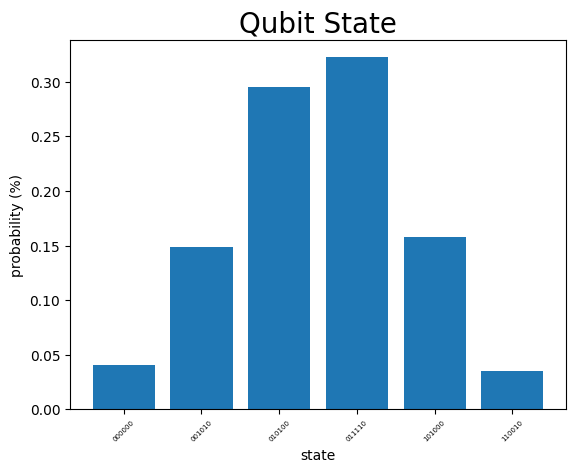

In [7]:
# plot probabilities of each states
q_state_L = []
q_prob_L = []
for state in qubit_state_L:
    q_state_L.append(state[0])
    q_prob_L.append(state[1])

plt.bar(q_state_L,q_prob_L)
#plt.legend(fontsize=15)
plt.xlabel("state", size=10)
plt.ylabel("probability (%)", size=10)
plt.title("Qubit State", size=20)
plt.xticks(size=5,rotation=45)
plt.yticks(size=10)
plt.show()